## Семинар 2 "Распознавание рукописных цифр"

ФИО: Новак Александр Вадимович

В этом задании мы используем нейронную сеть из предыдущего семинара для распознавания рукописных цифр. Также мы исследуем как влияет выбор нелинейности и предобработка данных на качество классификации. 

Чтобы не тратить время на подготовку данных, мы прилагаем готовый код с примером использования для получения обучающей и тестовой выборок. Для запуска скрипта вам понадобится библиотека PyTorch (инструкции по установке можно найти на сайте <a href="http://pytorch.org">pytorch.org</a>)

In [11]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms

# I hadn't enough patience to wait for custom layers
from torch import nn, optim
# to define functions with custom forward and backward passes
from torch.autograd import Function
from torch import no_grad, max
from torch import Tensor
from torch import device, cuda

DEVICE = device("cuda:0" if cuda.is_available() else "cpu") 

import numpy as np
import sys
from IPython.display import clear_output
%matplotlib inline

In [12]:
def plot_train_results(loss_results: list, acc_results: list, labels: list) -> None:
    """plots loss and accuracy from given lists"""
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.title('Loss')
    for loss_result, label in zip(loss_results, labels):
        plt.plot(loss_result, label=label)

    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    for acc_result, label in zip(acc_results, labels):
        plt.plot(acc_result, label=label)

    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid()
    plt.show()

In [13]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)

test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
train_loader.dataset.train_data = train_loader.dataset.train_data.to(DEVICE)
train_loader.dataset.train_labels = train_loader.dataset.train_labels.to(DEVICE)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
test_loader.dataset.test_data = test_loader.dataset.test_data.to(DEVICE)
test_loader.dataset.test_labels = test_loader.dataset.test_labels.to(DEVICE)

c:\Users\Sasha.WIN7PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\datasets\mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
c:\Users\Sasha.WIN7PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\datasets\mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [14]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

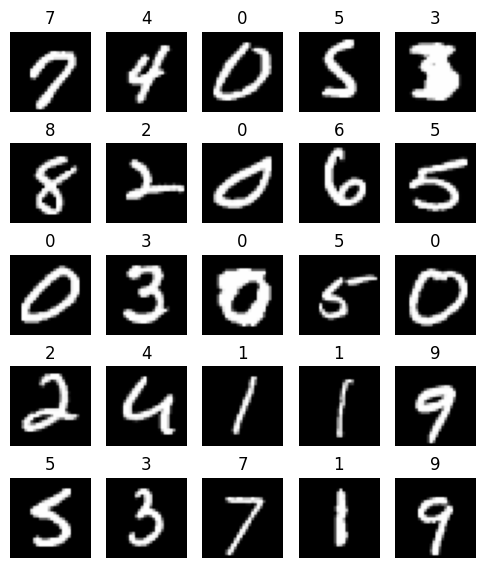

In [15]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

### Часть 1: MNIST
Обучите полносвязную нейронную сеть с архитектурой 784-100-100-10 и сигмоидой в качестве нелинейности. Какую точность классификации удалось получить? Нарисуйте график сходимости на обучающей и тестовой выборках. В качестве темпа обучения (learning rate) возьмите 0.01

In [16]:
NUM_EPOCHS = 8

In [17]:
def train_and_evaluate(model, train_loader: DataLoader, test_loader: DataLoader, 
                       num_epochs: int = NUM_EPOCHS, learning_rate = 0.01):
    loss = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    for epoch in range(num_epochs):
        train_loss = 0.0
        train_accuracy = 0.0
        test_loss = 0.0
        test_accuracy = 0.0
        for _, (inputs, targets) in enumerate(train_loader):
            outputs = model(inputs)
            curr_loss = loss(outputs, targets)

            optimizer.zero_grad()
            curr_loss.backward()
            optimizer.step()

            _, predicted = max(outputs.data, 1)
            accuracy = (predicted == targets).float().mean() * 100.0

            train_loss += curr_loss.item()
            train_accuracy += accuracy.item()

        train_loss /= len(train_loader)
        train_accuracy /= len(train_loader)
        
        print(f"{epoch=} {train_loss=} {train_accuracy=}")

        train_losses += [train_loss]
        train_accuracies += [train_accuracy]

        with no_grad():
            for _, (inputs, targets) in enumerate(test_loader):
                outputs = model(inputs)
                _, predicted = max(outputs.data, 1)
                test_loss += loss(outputs, targets).item()
                test_accuracy += (predicted == targets).float().mean() * 100.0

            test_loss /= len(test_loader)
            test_accuracy /= len(test_loader)

            test_losses += [test_loss]
            test_accuracies += [test_accuracy]
            
    plot_train_results(loss_results=[train_losses, test_losses], acc_results=[train_accuracies, test_accuracies],
                       labels=["Train", "Test"])
    return train_losses, test_losses, train_accuracies, test_accuracies

In [18]:
network_s = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 100),
    nn.Sigmoid(),
    nn.Linear(100, 100),
    nn.Sigmoid(),
    nn.Linear(100, 10),
    nn.Softmax()
).to(DEVICE)

c:\Users\Sasha.WIN7PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


epoch=0 train_loss=1.6388265637079875 train_accuracy=82.745
epoch=1 train_loss=1.5768877916971842 train_accuracy=88.51666666666667
epoch=2 train_loss=1.5718195988972983 train_accuracy=88.94666666666667
epoch=3 train_loss=1.560835783513387 train_accuracy=90.06
epoch=4 train_loss=1.5595438543319702 train_accuracy=90.165
epoch=5 train_loss=1.5602173993428547 train_accuracy=90.10166666666667
epoch=6 train_loss=1.5534660576502481 train_accuracy=90.82666666666667
epoch=7 train_loss=1.5632520905812581 train_accuracy=89.82


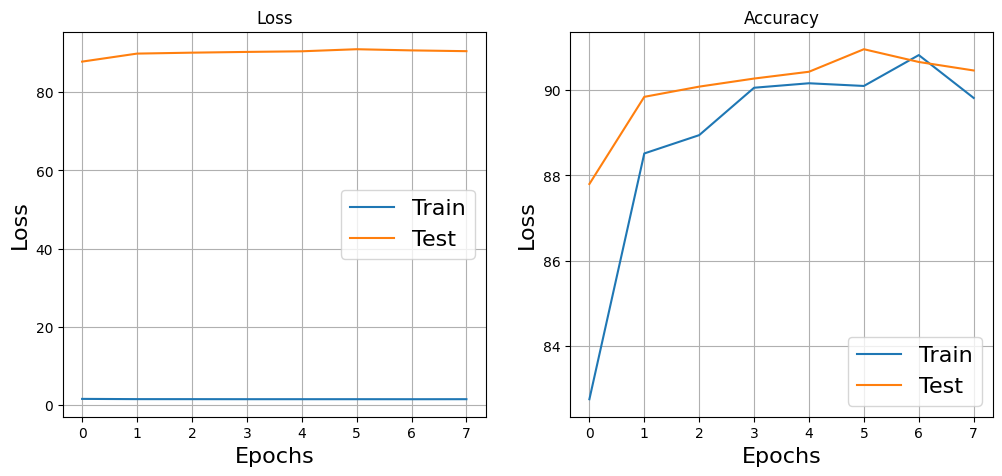

In [19]:
tr_s, ts_s, tr_ac_s, ts_ac_s = train_and_evaluate(network_s, train_loader, test_loader, NUM_EPOCHS, 0.01)

### Часть 2: Нелинейности

In [ ]:
class ActivationWrapper(nn.Module):
    def __init__(self, activation: Function):
        super(ActivationWrapper, self).__init__()
        self.activation = activation
    
    def forward(self, input):
        return self.activation(input)

Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

In [23]:
class ReLU(Function):
    @staticmethod
    def forward(ctx, X):
        ctx.save_for_backward(X)
        return np.maximum(X, 0)

    @staticmethod
    def backward(ctx, dLdy):
        X, = ctx.saved_tensors
        return (X > 0) * dLdy
    

In [21]:
class ELU(Function):
    @staticmethod
    def forward(ctx, X):
        a = 1
        ctx.save_for_backward(X)
        return X * (X > 0) + a * (np.exp(X) - 1) * (X <= 0)

    @staticmethod
    def backward(ctx, dLdy):
        a = 1
        X, = ctx.saved_tensors
        dydX = (X > 0) + a * np.exp(X) * (X <= 0)
        return dLdy*dydX

In [24]:
network_r = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 100),
    ActivationWrapper(ReLU()),
    nn.Linear(100, 100),
    ActivationWrapper(ReLU()),
    nn.Linear(100, 10),
    nn.Softmax()
).to(DEVICE)

tr_r, ts_r, tr_ac_r, ts_ac_r = train_and_evaluate(network_r, train_loader, test_loader, NUM_EPOCHS, 0.01)

TypeError: __main__.ReLU is not a Module subclass

In [ ]:
network_e = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 100),
    ActivationWrapper(ELU()),
    nn.Linear(100, 100),
    ActivationWrapper(ELU()),
    nn.Linear(100, 10),
    nn.Softmax()
).to(DEVICE)

tr_e, ts_e, tr_ac_e, ts_ac_e = train_and_evaluate(network_e, train_loader, test_loader, NUM_EPOCHS, 0.01)

In [ ]:
plot_train_results(loss_results=[ts_s, ts_r, ts_e], acc_results=[ts_ac_s, ts_ac_r, ts_ac_e],
                       labels=["Sigmoid", "ReLU", "ELU"])

### HW1 (1 балл): Реализовать Tanh

In [ ]:
class Tanh(Function):
    '''
    Tanh(x) = (e^(2x) - 1) / (e^(2x) + 1)
    '''
    @staticmethod
    def forward(ctx, X):
        exp = np.exp(2 * X)
        result = (exp - 1) / (exp + 1)
        ctx.save_for_backward(result)
        return result

    @staticmethod
    def backward(ctx, dLdy):
        result, = ctx.saved_tensors
        return (1 - result ** 2) * dLdy

In [ ]:
network_t = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 100),
    ActivationWrapper(Tanh()),
    nn.Linear(100, 100),
    ActivationWrapper(Tanh()),
    nn.Linear(100, 10),
    nn.Softmax()
).to(DEVICE)

tr_t, ts_t, tr_ac_t, ts_ac_t = train_and_evaluate(network_t, train_loader, test_loader, NUM_EPOCHS, 0.01)

In [ ]:
plot_train_results(loss_results=[ts_s, ts_r, ts_e, ts_t], 
                        acc_results=[ts_ac_s, ts_ac_r, ts_ac_e, ts_ac_t],
                        labels=["Sigmoid", "ReLU", "ELU", "Tanh"])

### Часть 3: Анализ ошибок

In [ ]:
wrong_X = []
correct_y = []
predicted_y = []
logits = []
for X, y in test_loader:
    X = X.view(X.shape[0], -1).numpy()
    y = y.numpy()
    prediction = network_t.forward(X)
    prediction = np.exp(prediction)
    prediction /= prediction.sum(1, keepdims=True)
    for i in range(len(prediction)):
        if np.argmax(prediction[i]) != y[i]:
            wrong_X.append(X[i])
            correct_y.append(y[i])
            predicted_y.append(np.argmax(prediction[i]))
            logits.append(prediction[i][y[i]])
wrong_X = np.row_stack(wrong_X)
correct_y = np.row_stack(correct_y)[:, 0]
predicted_y = np.row_stack(predicted_y)[:, 0]
logits = np.row_stack(logits)[:, 0]

In [ ]:
plt.figure(figsize=(10, 5))
order = np.argsort(logits)
for i in range(21):
    plt.subplot(3, 7, i+1)
    plt.imshow(wrong_X[order[i]].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title('{}({})'.format(correct_y[order[i]], predicted_y[order[i]]), fontsize=20)
    plt.axis('off')

### Часть 4: Аугментация (HW, 2 балла)
* Небольшие вращения (-15, 15)
* Случайные сдвиги
* Шум

Какой прирост дают эти аугментации вместе и по отдельности

In [ ]:
# !pip install scikit-image
from skimage.transform import rotate

transform_rotation = transforms.Compose([
                      transforms.RandomRotation(15),
                      transforms.ToTensor(),
                      transforms.Normalize((0.1307,), (0.3081,))
                    ])

In [ ]:
train_dataset_rot = MNIST('.', train=True, download=True, transform=transform_rotation)

train_loader_rot = DataLoader(train_dataset_rot, batch_size=32, shuffle=True)
train_loader_rot.dataset.train_data = train_loader_rot.dataset.train_data.to(DEVICE)
train_loader_rot.dataset.train_labels = train_loader_rot.dataset.train_labels.to(DEVICE)

In [ ]:
network_rot = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 100),
    ActivationWrapper(ReLU()),
    nn.Linear(100, 100),
    ActivationWrapper(ReLU()),
    nn.Linear(100, 10),
    nn.Softmax()
).to(DEVICE)
tr_rot, ts_rot, tr_ac_rot, ts_ac_rot = train_and_evaluate(network_rot, 
                                                          train_loader_rot, 
                                                          test_loader, NUM_EPOCHS, 0.01)

In [ ]:
transform_translation = transforms.Compose([
                          transforms.RandomAffine(degrees=0, translate=(0.05,0.05)),
                          transforms.ToTensor(),
                          transforms.Normalize((0.1307,), (0.3081,))
                        ])

In [ ]:
train_dataset_tr = MNIST('.', train=True, download=True, transform=transform_translation)

train_loader_tr = DataLoader(train_dataset_tr, batch_size=32, shuffle=True)
train_loader_tr.dataset.train_data = train_loader_tr.dataset.train_data.to(DEVICE)
train_loader_tr.dataset.train_labels = train_loader_tr.dataset.train_labels.to(DEVICE)

In [ ]:
network_tr = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 100),
    ActivationWrapper(ReLU()),
    nn.Linear(100, 100),
    ActivationWrapper(ReLU()),
    nn.Linear(100, 10),
    nn.Softmax()
).to(DEVICE)
tr_tr, ts_tr, tr_ac_tr, ts_ac_tr = train_and_evaluate(network_tr, 
                                                      train_loader_tr, 
                                                      test_loader, NUM_EPOCHS, 0.01)

In [ ]:
from torch import Generator, rand

class GaussianNoiseTransform(object):
    """ adds normal (gaussian) noise"""
    def __init__(self, mean: float = 0., std: float = 1., initial_seed = None):
        self.std = std
        self.mean = mean
        self.generator = Generator()
        if initial_seed is not None:
          self.generator.manual_seed(initial_seed)
        
    def __call__(self, tensor):
        return tensor + rand(tensor.size(), generator = self.generator) * \
          self.std + self.mean

transform_noise = transforms.Compose([
                          GaussianNoiseTransform(),
                          transforms.ToTensor(),
                          transforms.Normalize((0.1307,), (0.3081,))
                        ])

In [ ]:
train_dataset_n = MNIST('.', train=True, download=True, transform=transform_translation)

train_loader_n = DataLoader(train_dataset_n, batch_size=32, shuffle=True)
train_loader_n.dataset.train_data = train_loader_n.dataset.train_data.to(DEVICE)
train_loader_n.dataset.train_labels = train_loader_n.dataset.train_labels.to(DEVICE)

In [ ]:
network_n = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 100),
    ActivationWrapper(ReLU()),
    nn.Linear(100, 100),
    ActivationWrapper(ReLU()),
    nn.Linear(100, 10),
    nn.Softmax()
).to(DEVICE)
tr_n, ts_n, tr_ac_n, ts_ac_n = train_and_evaluate(network_n, 
                                                  train_loader_n, 
                                                  test_loader, NUM_EPOCHS, 0.01)

In [ ]:
transform_all = transforms.Compose([
                          transforms.RandomAffine(degrees=15, translate=(0.05,0.05)),
                          GaussianNoiseTransform(),
                          transforms.ToTensor(),
                          transforms.Normalize((0.1307,), (0.3081,))
                        ])

In [ ]:
train_dataset_all = MNIST('.', train=True, download=True, transform=transform_translation)

train_loader_all = DataLoader(train_dataset_all, batch_size=32, shuffle=True)
train_loader_all.dataset.train_data = train_loader_all.dataset.train_data.to(DEVICE)
train_loader_all.dataset.train_labels = train_loader_all.dataset.train_labels.to(DEVICE)

In [ ]:
network_all = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 100),
    ActivationWrapper(ReLU()),
    nn.Linear(100, 100),
    ActivationWrapper(ReLU()),
    nn.Linear(100, 10),
    nn.Softmax()
).to(DEVICE)
tr_all, ts_all, tr_ac_all, ts_ac_all = train_and_evaluate(network_all, 
                                                  train_loader_all, 
                                                  test_loader, NUM_EPOCHS, 0.01)

In [ ]:
plot_train_results(loss_results=[ts_r, ts_rot, ts_tr, ts_n, ts_all], 
                        acc_results=[ts_ac_r, ts_ac_rot, ts_ac_tr, ts_ac_n, ts_ac_all],
                        labels=["No augmentation", "Rotation", "Translation", "Noise", "All"])

### Часть 5: Выводы
Опишите полученные результаты: как влияют выбор нелинейности и предобработка данных на скорость сходимости и итоговое качество?